In [ ]:
import pandas as pd
import string
import spacy
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("/Users/kevinhsu/Downloads/AIT 526/Skynet/Sentiment Analysis Dataset/train.csv", encoding='ISO-8859-1')

In [81]:
df.dropna(subset=['text'], inplace=True)

In [86]:
def preprocess_text(text):
    doc = nlp(text)
    clean_tokens = [
        token.lemma_.lower()
        for token in doc
        if token.text not in string.punctuation  # remove punctuation
        and not token.is_stop                    # remove stopwords
        and token.lemma_ != "-PRON-"             # exclude pronouns
    ]
    return " ".join(clean_tokens)

df['processed_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Bag of Words
from sklearn.feature_extraction.text import CountVectorizer
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer()
vectorizer = CountVectorizer()

In [88]:
X = vectorizer.fit_transform(df['processed_text'])

In [83]:
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [101]:
models = {
    "XGBoost": XGBClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

In [102]:
# Define vectorizers
vectorizers = {
    "Count Vectorizer": CountVectorizer(),
    "TF-IDF": TfidfVectorizer()
}

# Store results for each combination
all_results = {}

# Test each vectorizer
for vec_name, vectorizer in vectorizers.items():
    # Transform the data
    X = vectorizer.fit_transform(df['processed_text'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Test each model with current vectorizer
    model_results = {}
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        model_results[model_name] = acc
    
    all_results[vec_name] = model_results

# Display results
print("Model performance with different vectorizers:\n")
for vec_name, model_results in all_results.items():
    print(f"\n{vec_name}:")
    print("-" * 40)
    for model_name, acc in model_results.items():
        print(f"{model_name}: {acc:.4f}")

# Find best combination
best_acc = 0
best_vec = ""
best_model = ""

for vec_name, model_results in all_results.items():
    for model_name, acc in model_results.items():
        if acc > best_acc:
            best_acc = acc
            best_vec = vec_name
            best_model = model_name

print(f"\nBest combination:")
print(f"Vectorizer: {best_vec}")
print(f"Model: {best_model}")
print(f"Accuracy: {best_acc:.4f}")

Model performance with different vectorizers:


Count Vectorizer:
----------------------------------------
XGBoost: 0.6960
Logistic Regression: 0.6881
Naive Bayes: 0.6412
Random Forest: 0.6940
Gradient Boosting: 0.6499
Support Vector Machine: 0.6920
K-Nearest Neighbors: 0.5626

TF-IDF:
----------------------------------------
XGBoost: 0.6904
Logistic Regression: 0.6800
Naive Bayes: 0.6194
Random Forest: 0.7003
Gradient Boosting: 0.6500
Support Vector Machine: 0.6803
K-Nearest Neighbors: 0.4514

Best combination:
Vectorizer: TF-IDF
Model: Random Forest
Accuracy: 0.7003


#### Model performance with different vectorizers:

#### **Bag of Words:**
##### ----------------------------------------
##### XGBoost: 0.6960
##### Logistic Regression: 0.6881
##### Naive Bayes: 0.6412
##### Random Forest: 0.6940
##### Gradient Boosting: 0.6499
##### Support Vector Machine: 0.6920
##### K-Nearest Neighbors: 0.5626

#### **TF-IDF:**
##### ----------------------------------------
##### XGBoost: 0.6904
##### Logistic Regression: 0.6800
##### Naive Bayes: 0.6194
##### Random Forest: 0.7003
##### Gradient Boosting: 0.6500
##### Support Vector Machine: 0.6803
##### K-Nearest Neighbors: 0.4514

#### Best combination:
##### Vectorizer: TF-IDF
##### Model: Random Forest
##### Accuracy: 0.7003

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = models[best_model]
X = df['processed_text']
y = df['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([
    ('vectorizer', vectorizers[best_vec]),
    ('classifier', model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2]))


Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.59      0.65      2356
     neutral       0.66      0.74      0.70      3343
    positive       0.74      0.77      0.76      2545

    accuracy                           0.70      8244
   macro avg       0.71      0.70      0.70      8244
weighted avg       0.71      0.70      0.70      8244


Confusion Matrix:
[[1384  765  207]
 [ 406 2460  477]
 [  92  494 1959]]


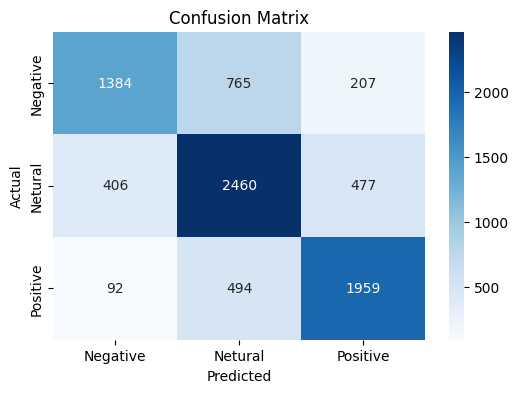

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# y_test = actual labels, y_pred = predicted labels from your model
conf_mat = confusion_matrix(y_test, y_pred)

# Optional: add class names
labels = ['Negative', 'Netural', 'Positive']  # change according to your classes

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()